In [4]:
import numpy as np
import torchaudio
import torch


%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, Audio

In [5]:
X = torch.from_numpy(np.load('datasets/voices_sr8000_dur2.0.npy'))

In [6]:
n_fft = 400

y = X[:1]
print(y.shape)


spec = y.stft(n_fft).permute(0, -1, -3, -2)
print(spec.shape)
y_p = torchaudio.functional.istft(spec.permute(0, -2, -1, -3), n_fft)


print(y_p.shape)

torch.Size([1, 16000])
torch.Size([1, 2, 201, 161])
torch.Size([1, 16000])


In [7]:
display(Audio(y[0], rate=8000))
display(Audio(y_p[0], rate=8000))

In [8]:
y.stft(300, ).shape

torch.Size([1, 151, 214, 2])

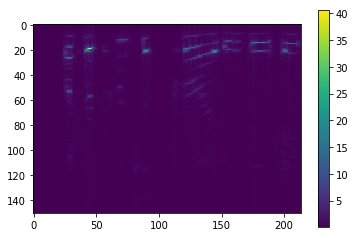

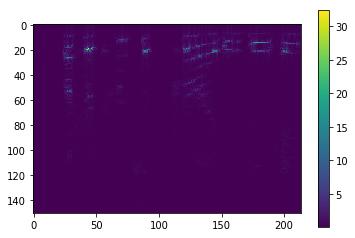

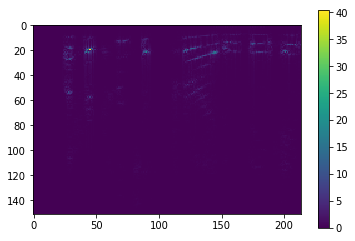

In [9]:
plt.imshow(y.stft(300, normalized=False).norm(dim=-1, ).numpy()[0])
plt.colorbar()
plt.show()

plt.imshow(y.stft(300, normalized=False)[..., 0].abs().numpy()[0])
plt.colorbar()
plt.show()

plt.imshow(y.stft(300, normalized=False)[..., 1].abs().numpy()[0])
plt.colorbar()
plt.show()

In [51]:
import audio_ss_nnio

import matplotlib.pyplot as plt

import numpy as np

class BaseNNIO(audio_ss_nnio.AudioSSNNIO):
    def __init__(self, sr, duration, n_fft=300, normalized=False, magphase_representation=False):
        super().__init__(sr, duration)
        self.n_fft = n_fft
        self.normalized = normalized
        self.magphase_representation = magphase_representation
        
    def audio_to_nn_input(self, X_batch):
        # X_batch is (batch_size, len(y))
        
        X_batch = X_batch.stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        if self.magphase_representation: # magphase
            X_batch_mag, X_batch_phase = torchaudio.functional.magphase(X_batch)
            X_batch = torch.stack((X_batch_mag, X_batch_phase), dim=-1)
        X_batch =  X_batch.permute(0, -1, -3, -2) # shape
        return X_batch
    
    def audio_to_nn_output(self, Y_batch):
        # Y_batch is (batch_size, num_sources=2, len(y))
        Y_batch = Y_batch[:, 0, :].stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        if self.magphase_representation: #magphase
            Y_batch_mag, Y_batch_phase = torchaudio.functional.magphase(Y_batch)
            Y_batch = torch.stack((Y_batch_mag, Y_batch_phase), dim=-1)
        Y_batch = Y_batch.permute(0, -1, -3, -2) # shape
        return Y_batch
    
    def nn_input_to_audio(self, X_batch):
        X_batch = X_batch.permute(0, -2, -1, -3) # shape
        if self.magphase_representation: # magphase
            X_batch_real = X_batch[..., 0] * torch.cos(X_batch[..., 1])
            X_batch_imag = X_batch[..., 0] * torch.sin(X_batch[..., 1])
            X_batch = torch.stack((X_batch_real, X_batch_imag), dim=-1)
        
        X_batch = torchaudio.functional.istft(X_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(self.sr*self.duration))
        
        return X_batch
    def nn_output_to_audio(self, Y_batch, X_batch, transform_X_batch=True):
        Y_batch = Y_batch.permute(0, -2, -1, -3) # shape
        if self.magphase_representation: # magphase
            Y_batch_real = Y_batch[..., 0] * torch.cos(Y_batch[..., 1])
            Y_batch_imag = Y_batch[..., 0] * torch.sin(Y_batch[..., 1])
            Y_batch = torch.stack((Y_batch_real, Y_batch_imag), dim=-1)
        
        Y_batch = torchaudio.functional.istft(Y_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(self.sr*self.duration))
        
        if transform_X_batch:
            X_batch = self.nn_input_to_audio(X_batch)
        
        Y_batch_noise = X_batch - Y_batch
        
        Y_batch = torch.stack((Y_batch, Y_batch_noise), dim=-2)
        return Y_batch
        
        
    # for jupyter notebook only
    def show_play_audio(self, y, ts=['raw', 'audio']):
        spectrogram = y.stft(n_fft=self.n_fft, normalized=self.normalized)
        spec_mag, spec_phase = torchaudio.functional.magphase(spectrogram)
        
        if 'mag' in ts:
            plt.figure(figsize=(10,4))
            plt.imshow(spec_mag.numpy())
            plt.colorbar(format='%2.2f')
            plt.title('Magnitude of STFT')
            plt.tight_layout()
            plt.show()
        if 'detail' in ts:
            fig, axs = plt.subplots(2,2, figsize=(10,4))
            axs[0, 0].set_title('Magnitude')
            axs[0, 1].set_title('Phase')
            axs[1, 0].set_title('Real Part')
            axs[1, 1].set_title('Imag Part')
            
            axs[0, 0].imshow(spec_mag.numpy())
            axs[0, 1].imshow(spec_phase.numpy())
            axs[1, 0].imshow(spectrogram[..., 0].numpy())
            axs[1, 1].imshow(spectrogram[..., 1].numpy())
            plt.show()
        super().show_play_audio(y, ts)


In [52]:
base = BaseNNIO(8000, 2.0, magphase_representation=True)

In [53]:
Y = torch.stack((X[:10], X[:10]), dim=-2)
print(Y.shape)

torch.Size([10, 2, 16000])


In [54]:
X[:10].shape

torch.Size([10, 16000])

# Error Checking

In [55]:
(base.nn_input_to_audio(base.audio_to_nn_input(X[:10]))-X[:10]).abs().sum()

tensor(0.0005)

In [58]:
(base.nn_output_to_audio(base.audio_to_nn_output(Y), 2*X[:10], transform_X_batch=False)-Y).abs().sum()

tensor(0.0009)

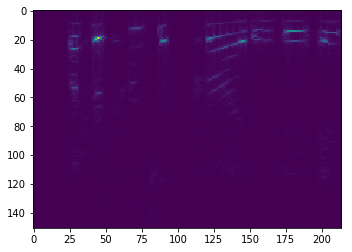

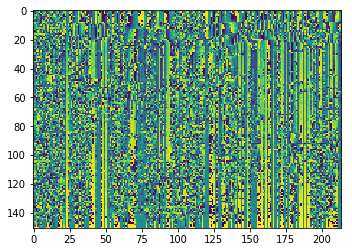

In [30]:
plt.imshow(base.audio_to_nn_input(X[:1])[0, 0])
plt.show()
plt.imshow(base.audio_to_nn_input(X[:1])[0, 1])
plt.show()

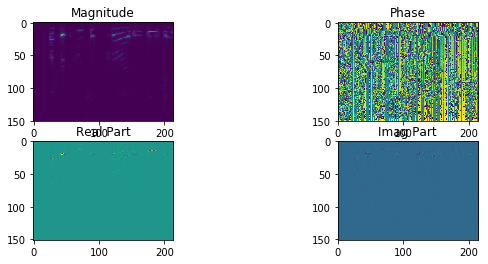

In [31]:
base.show_play_audio(X[0], ts=['detail'])